In [1]:
import os
import copy
from pathlib import Path
from typing import Union, List, Literal, Dict, Callable, Tuple
import random

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

In [2]:
emory = pd.read_csv('emory_final.csv')
vini = pd.read_csv('vinidir_final.csv')

In [3]:
vini = vini.rename(columns={'image_paths':'image_path'})
emory = emory.rename(columns={'Image_Paths':'image_path'})

In [4]:
emory['image_path'] = emory['image_path'].str.replace(r'^../', '', regex=True)

In [5]:
vini['patient_id'] = vini['image_path'].apply(lambda x: x.split('/')[2])
emory['patient_id'] = emory['image_path'].apply(lambda x:x.split('/')[2])

In [6]:
emory_f = emory[(emory['asses']!='BIRADS 0') & (emory['asses']!='BIRADS 6')].reset_index(drop=True)

emory_f['asses'] = emory_f['asses'].str.replace(' ', '').str.upper()
vini['breast_birads'] = vini['breast_birads'].str.replace('-', '').str.replace(' ', '').str.upper()

# Rename columns for clarity and merge datasets
emory_f = emory_f.rename(columns={'asses': 'breast_birads', 'ViewPosition':'view','ImageLateralityFinal':'laterality'})

In [7]:
cc_mammo = vini[vini['view'] == 'CC'][['patient_id', 'image_path', 'view','laterality','breast_birads']].reset_index(drop=True)
mlo_mammo = vini[vini['view'] == 'MLO'][['patient_id', 'image_path', 'view','laterality','breast_birads']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
})

vini_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [8]:
cc_mammo = emory_f[emory_f['view'] == 'CC'][['patient_id', 'image_path', 'view','laterality','breast_birads']].reset_index(drop=True)
mlo_mammo = emory_f[emory_f['view'] == 'MLO'][['patient_id', 'image_path', 'view','laterality','breast_birads']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
})

emory_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [9]:
data = pd.concat([
    vini_merged[['patient_id','image_path_CC','image_path_MLO','breast_birads_CC','breast_birads_MLO','view_x','view_y']],
    emory_merged[['patient_id','image_path_CC','image_path_MLO','breast_birads_CC','breast_birads_MLO','view_x','view_y']],
], axis=0).reset_index(drop=True)

In [10]:
# Filter out rows with BIRADS5 in either breast_birads_CC or breast_birads_MLO
filtered_data = data[~data['breast_birads_CC'].isin(['BIRADS5']) & ~data['breast_birads_MLO'].isin(['BIRADS5'])]

# Group by both breast_birads_CC and breast_birads_MLO to ensure balanced sampling across classes
# Use .apply with .sample to get 700 samples for each group
balanced_data = filtered_data.groupby(['breast_birads_CC', 'breast_birads_MLO'], group_keys=False).apply(
    lambda x: x.sample(n=min(1200, len(x)), random_state=42)
)

balanced_data = balanced_data.reset_index(drop=True)
balanced_data.head()


,patient_id,image_path_CC,image_path_MLO,breast_birads_CC,breast_birads_MLO,view_x,view_y
0,61f3d797233b229db610017bd62dc862,vinidr-mammogram-dataset/images_png/61f3d79723...,vinidr-mammogram-dataset/images_png/61f3d79723...,BIRADS1,BIRADS1,CC,MLO
1,164f0e6a330b6e498aea7032530b49f0,vinidr-mammogram-dataset/images_png/164f0e6a33...,vinidr-mammogram-dataset/images_png/164f0e6a33...,BIRADS1,BIRADS1,CC,MLO
2,10575833,emory/images_png/10575833/1.2.844.113689.27508...,emory/images_png/10575833/1.2.847.113684.27508...,BIRADS1,BIRADS1,CC,MLO
3,caa4eba9b95ac07e8063ff87e90b60ee,vinidr-mammogram-dataset/images_png/caa4eba9b9...,vinidr-mammogram-dataset/images_png/caa4eba9b9...,BIRADS1,BIRADS1,CC,MLO
4,63daec7e094feedd1d827bf750a144e8,vinidr-mammogram-dataset/images_png/63daec7e09...,vinidr-mammogram-dataset/images_png/63daec7e09...,BIRADS1,BIRADS1,CC,MLO


In [11]:
# Define the mapping dictionary
birads_mapping = {
    'BIRADS1': 0,
    'BIRADS2': 1,
    'BIRADS3': 2,
    'BIRADS4': 3,
}

# Map the breast_birads columns to numeric identifiers
balanced_data['breast_birads_CC'] = balanced_data['breast_birads_CC'].map(birads_mapping)
balanced_data['breast_birads_MLO'] = balanced_data['breast_birads_MLO'].map(birads_mapping)
balanced_data.head()

,patient_id,image_path_CC,image_path_MLO,breast_birads_CC,breast_birads_MLO,view_x,view_y
0,61f3d797233b229db610017bd62dc862,vinidr-mammogram-dataset/images_png/61f3d79723...,vinidr-mammogram-dataset/images_png/61f3d79723...,0,0,CC,MLO
1,164f0e6a330b6e498aea7032530b49f0,vinidr-mammogram-dataset/images_png/164f0e6a33...,vinidr-mammogram-dataset/images_png/164f0e6a33...,0,0,CC,MLO
2,10575833,emory/images_png/10575833/1.2.844.113689.27508...,emory/images_png/10575833/1.2.847.113684.27508...,0,0,CC,MLO
3,caa4eba9b95ac07e8063ff87e90b60ee,vinidr-mammogram-dataset/images_png/caa4eba9b9...,vinidr-mammogram-dataset/images_png/caa4eba9b9...,0,0,CC,MLO
4,63daec7e094feedd1d827bf750a144e8,vinidr-mammogram-dataset/images_png/63daec7e09...,vinidr-mammogram-dataset/images_png/63daec7e09...,0,0,CC,MLO


In [12]:
from sklearn.model_selection import train_test_split

t, test = train_test_split(balanced_data, test_size=0.1)
train, val = train_test_split(t, test_size=0.1)

In [13]:
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [14]:
def display_grid(data):
    idx = random.sample(range(data.shape[0]), 4)
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 10))

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_paL = row.image_path_CC
        img_file_paR = row.image_path_MLO

        # Open and show image
        imgL = Image.open(img_file_paL)
        imgR = Image.open(img_file_paR)
        try:
            axes[i, 0].imshow(imgL, cmap='gray')
            axes[i, 1].imshow(imgR, cmap='gray')
        except Exception as e:
            print(f"Cannot Display {img_file_paL} & {img_file_paR}, because of error:{e}")
        
        axes[i, 0].set_title(f"{i} {row.breast_birads_CC}")
        axes[i, 1].set_title(f"{i} {row.breast_birads_MLO}")
    
    plt.tight_layout()
    plt.show()



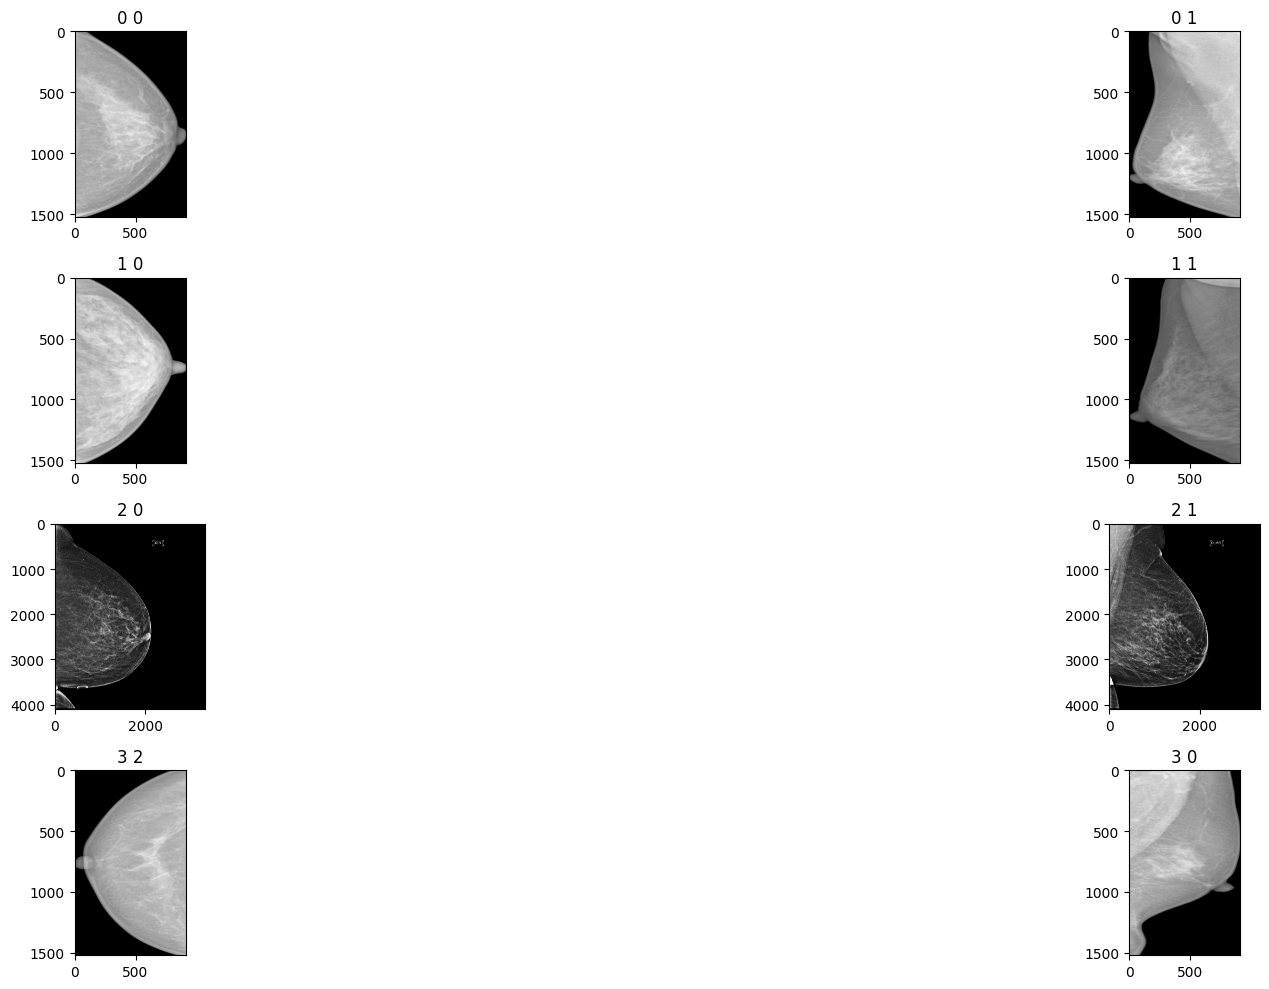

In [15]:
display_grid(train)

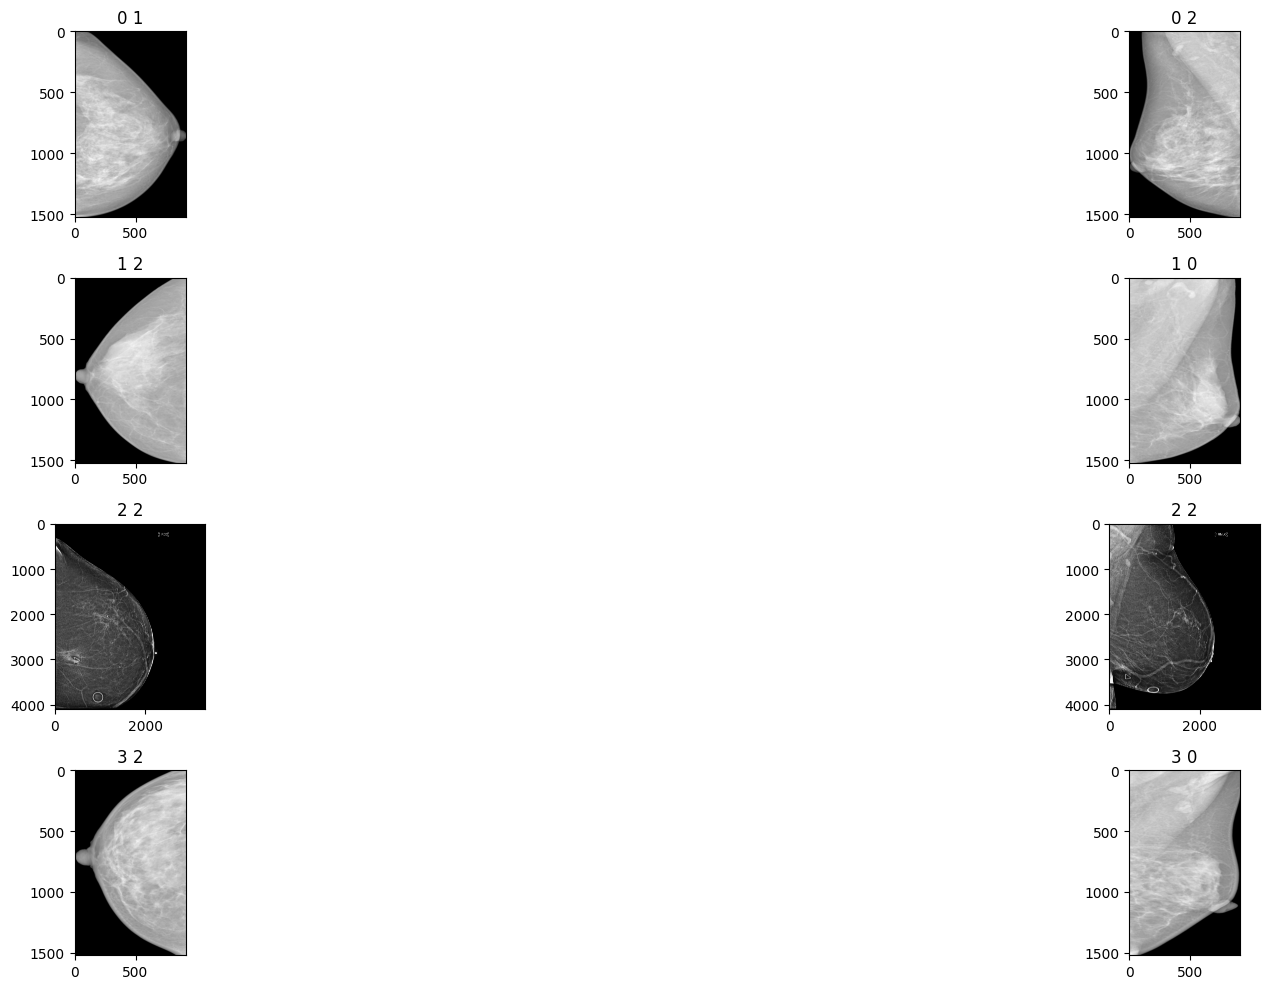

In [16]:
display_grid(val)

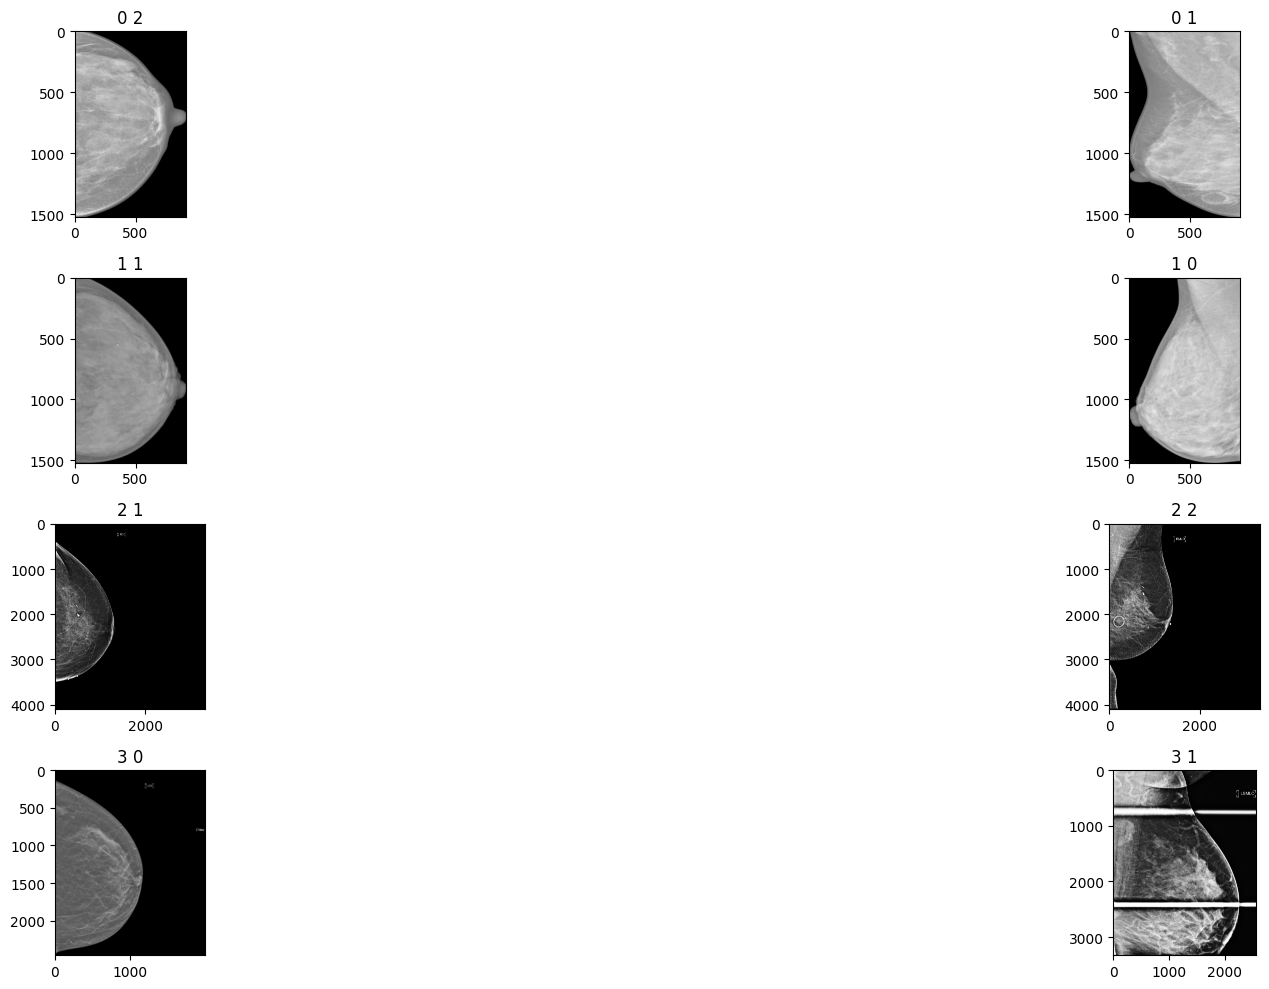

In [17]:
display_grid(test)

In [18]:
train_transforms = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.RandomCrop(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data_set: pd.DataFrame, transform=None):
        self.dataset = data_set
        self.transform = transform

    def __len__(self):
        return len(self.dataset['patient_id'])

    def __getitem__(self, idx):
        dict_data = {}
        
        # Retrieve paths
        image_path_1 = self.dataset['image_path_CC'].iloc[idx]
        image_path_2 = self.dataset['image_path_MLO'].iloc[idx]
        
        label_1 = self.dataset['breast_birads_CC'].iloc[idx]
        label_2 = self.dataset['breast_birads_MLO'].iloc[idx]
        
        try:
            # Load images as grayscale, then convert to RGB
            image_1 = Image.open(image_path_1).convert('L').convert('RGB')
            image_2 = Image.open(image_path_2).convert('L').convert('RGB')
            
            # Ensure images are numpy arrays
            image_1 = np.array(image_1)
            image_2 = np.array(image_2)
        except OSError:
            print(f"Error loading image at index {idx}. Replacing with previous valid image.")
            # Load the previous valid image as a fallback
            image_path_1 = self.dataset['image_path_CC'].iloc[idx - 1]
            image_path_2 = self.dataset['image_path_MLO'].iloc[idx - 1]
            label_1 = self.dataset['breast_birads_CC'].iloc[idx - 1]
            label_2 = self.dataset['breast_birads_MLO'].iloc[idx - 1]
            
            image_1 = Image.open(image_path_1).convert('L').convert('RGB')
            image_2 = Image.open(image_path_2).convert('L').convert('RGB')
            image_1 = np.array(image_1)
            image_2 = np.array(image_2)
        
        # Apply transformations if provided
        if self.transform is not None:
            img1 = self.transform(image=image_1)['image']
            img2 = self.transform(image=image_2)['image']
            dict_data.update({'images': {'img1': img1, 'img2': img2}})
        else:
            dict_data.update({'images': {'img1': image_1, 'img2': image_2}})
        
        # Convert labels to tensors
        label1_tensor = torch.tensor(float(label_1), dtype=torch.float32)
        label2_tensor = torch.tensor(float(label_2), dtype=torch.float32)
        
        dict_data.update({'labels': {'label1': label1_tensor, 'label2': label2_tensor}})
        
        return dict_data


In [20]:
train_dataset = CustomDataset(data_set=train, transform=train_transforms)
val_dataset = CustomDataset(data_set=val, transform=train_transforms)
test_dataset = CustomDataset(data_set =test, transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
} 

In [21]:
dact = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4373856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.55939].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.639

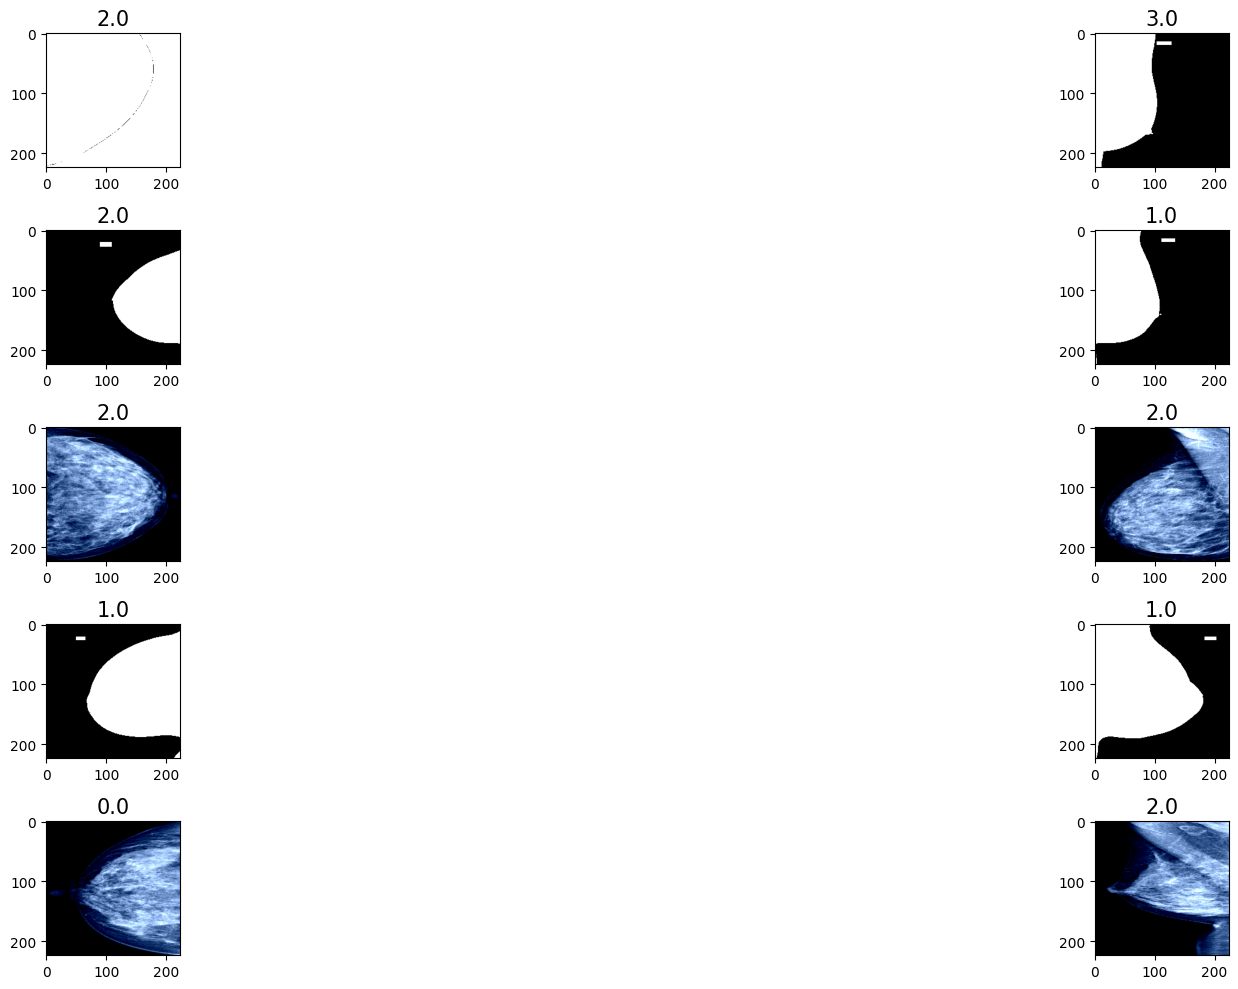

In [22]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,10))

for i in range(5):
    axs[i,0].imshow(dact['images']['img1'][i].numpy().transpose((1,2,0)))
    axs[i,1].imshow(dact['images']['img2'][i].numpy().transpose((1,2,0)))
    axs[i,0].set_title(f"{dact['labels']['label1'][i].item()}", size=15)
    axs[i,1].set_title(f"{dact['labels']['label2'][i].item()}", size=15)

plt.tight_layout()
plt.show()
    

In [23]:
def set_seed(seed : int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
class Efficient(nn.Module):
    def __init__(self, num_classes:int=4):
        super(Efficient, self).__init__()
        self.model = EfficientNet.from_pretrained("efficientnet-b0")
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1280, 512)
        
        self.fusion = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        x_cc = self.model.extract_features(images['img1'])
        x_cc = self.pool(x_cc)
        x_cc = x_cc.view(-1, 1280)
        x_cc = self.fc(x_cc)
        
        x_mlo = self.model.extract_features(images['img2'])
        x_mlo = self.pool(x_mlo)
        x_mlo = x_mlo.view(-1, 1280)
        x_mlo = self.fc(x_mlo)
        
        combined = torch.cat([x_cc, x_mlo], dim=1)
        return self.fusion(combined)

In [25]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, loaders: List[DataLoader], num_epochs: int = 10
               ) -> Tuple[nn.Module, List[float], List[float]]:  
    """
    Train a model on a dataset.

    Args:
      model: The model to train.
      criterion: The loss function.
      optimizer: The optimizer.
      scheduler: The learning_rate scheduler
      loaders: The training dataloader.
      num_epochs: The number of epochs to train for.

    Returns:
      A list of three elements. The first element is the model, the second element is a list of training losses, and the third element is a list of validation losses.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 10
    counter = 0
    train_loss = []
    valid_loss = []
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
                     
        # Training Phase
        model.train()
        running_corrects_T = 0
        running_loss_T = 0.0
        ns_T = 0
        train_dl = loaders['train']
        
        with tqdm(train_dl, desc=f"Training Epoch {epoch+1}") as pbar:

            for dict_data in pbar:
                images, labels = dict_data['images'], dict_data['labels']
                for img in images:
                    images[img] = images[img].to(device)
                label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
                y = torch.max(label1, label2).long()
                
                optimizer.zero_grad()
                outp = model(images)
                _, pred = torch.max(outp, 1)
                loss = criterion(outp, y)

                loss.backward()
                optimizer.step()
                running_loss_T += loss.item() * images['img1'].size(0)
                running_corrects_T += torch.sum(pred == y.data)
                ns_T += pred.shape[0]
                
                acc_value = running_corrects_T.double() / ns_T
                loss_value = running_loss_T/ ns_T
                metrics = {"Batch":f"Batch_{ns_T}","Train Accuracy":f"{acc_value:.3f}",
                           "Train Loss":f"{loss_value:.3f}"}
                pbar.set_postfix(metrics)
                
        # Validation Phase
        model.eval()

        ns_V = 0
        running_corrects_V = 0
        running_loss_V = 0.0
        valid_dl = loaders['val']
        
        with torch.no_grad():
            with tqdm(valid_dl, desc=f"Validation Epoch {epoch+1}") as pbar:

                for dict_data in pbar:
                    images, labels = dict_data['images'], dict_data['labels']
                    for img in images:
                        images[img] = images[img].to(device)
                    label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
                    y = torch.max(label1, label2).long()
                    optimizer.zero_grad()

                    outp = model(images)
                    _, pred = torch.max(outp, 1)
                    val_loss = criterion(outp, y)

                    running_loss_V += val_loss.item() * images['img1'].size(0)
                    ns_V += pred.shape[0]
                    running_corrects_V += torch.sum(pred == y.data)

                    acc_value = running_corrects_V.double() / ns_V
                    loss_value = running_loss_V/ ns_V

                    metrics = {"Val Accuracy":f"{acc_value:.3f}","Val Loss":f"{loss_value:.3f}"}
                    pbar.set_postfix(metrics)
                
        Train_loss = running_loss_T / len(train_dl.dataset)
        train_loss.append(Train_loss)
        Valid_loss = running_loss_V / len(valid_dl.dataset)
        valid_loss.append(Valid_loss)
        Train_acc = running_corrects_T.double() / ns_T
        Valid_acc = running_corrects_V.double() / ns_V
        
        scheduler.step(Valid_loss)
        print(f'Train Loss: {Train_loss:.4f} Train Acc: {Train_acc:.4f} Valid Loss: {Valid_loss:.4f} Valid Acc: {Valid_acc:.4f}')
    
        if Valid_acc > best_acc:
            best_acc = Valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(model.state_dict(), "EfficientNet_mammo.pth.tar")
            predict_image(model, valid_dl, list(birads_mapping.keys()))
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
            
            
    print('Best accuracy {}'.format(best_acc))            
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

In [31]:
def testpreds(model : nn.Module, test_dl : DataLoader) -> List:
    """
      Generates predictions for the test set.

      Args:
          model: The model to be evaluated.
          test_dl: The test dataloader.

      Returns:
          A list of predictions for the test set.
      """
    test_preds = []
    all_preds, all_labels = [], []
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        
        for dict_data in tqdm(test_dl, desc="testing"):
            images, labels = dict_data['images'], dict_data['labels']
            for img in images:
                images[img] = images[img].to(device)
            label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
            y = torch.max(label1, label2)

            outp = model(images)

            _, pred = torch.max(outp, 1)
            num_samples += pred.shape[0]
            num_correct += torch.sum(pred == y.data)

            # add to lists
            all_preds.append(pred.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())
        
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)

In [27]:
def predict_image(model:nn.Module, loader:DataLoader, class_names, count_images:int=3) -> None:
    model.eval()
    fig, axs = plt.subplots(1, count_images, figsize=(15, 10))
    
    num_images = count_images
    image_count = 0
    
    for dict_data in loader:
        images, labels = dict_data['images'], dict_data['labels']
        for img in images:
            images[img] = images[img].to(device)
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
        y = torch.max(label1, label2)
        
        with torch.no_grad():
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
       
            if image_count < num_images:

                image = images['img1'][image_count].permute(1, 2, 0).cpu().numpy()
                true_label = int(y[image_count].detach().cpu().item())
                predicted_label = int(predictions[image_count].detach().cpu().item())

                axs[image_count].imshow(image)
                axs[image_count].set_title(f'True: ({class_names[true_label]}),\n Predicted: ({class_names[predicted_label]})')
                axs[image_count].axis('off')

                image_count += 1
            else:
                break
        
        if image_count >= num_images:
            break
    
    plt.show()


## Training

Loaded pretrained weights for efficientnet-b0
Epoch 0/9
----------


Training Epoch 1:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.


Validation Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 1.2869 Train Acc: 0.4219 Valid Loss: 1.2965 Valid Acc: 0.4093


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6291068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


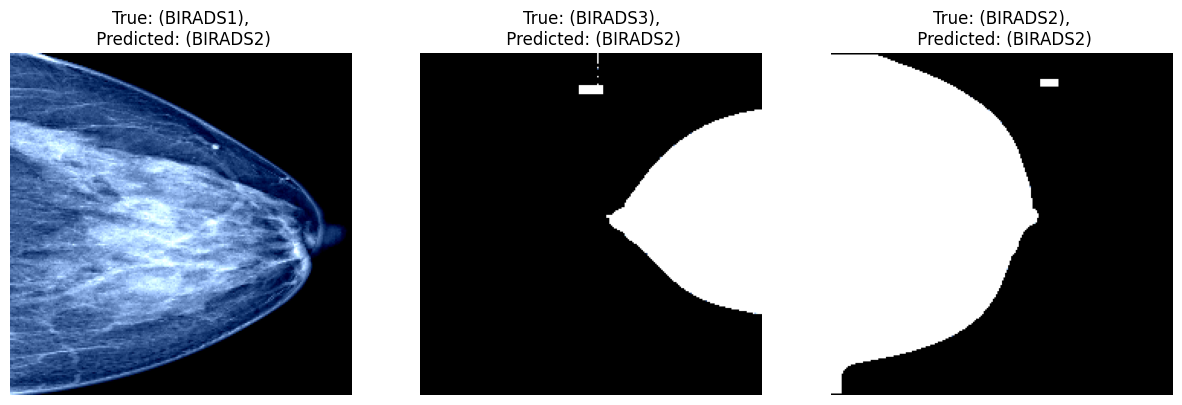

Epoch 1/9
----------


Training Epoch 2:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.


Validation Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 1.2231 Train Acc: 0.4485 Valid Loss: 1.2555 Valid Acc: 0.4458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.552854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7685403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


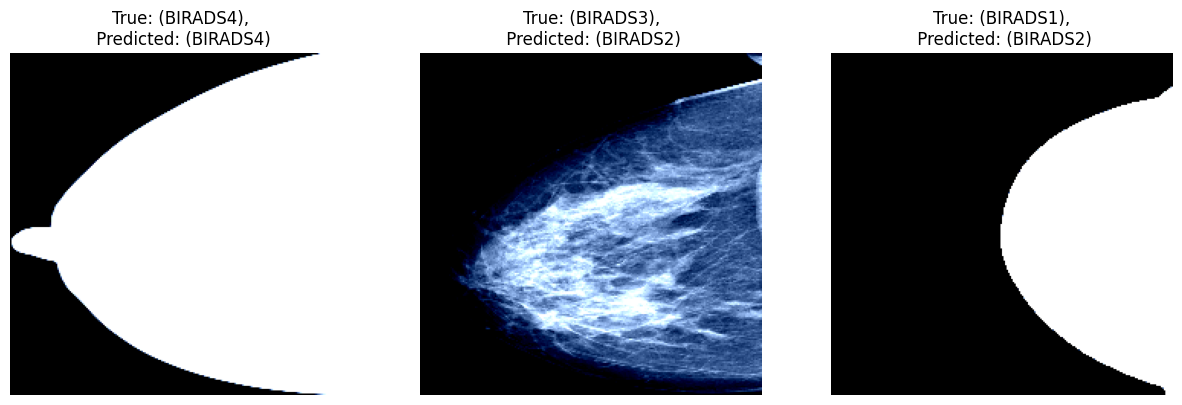

Epoch 2/9
----------


Training Epoch 3:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.


Validation Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 1.1480 Train Acc: 0.4905 Valid Loss: 1.2083 Valid Acc: 0.4597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6291068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


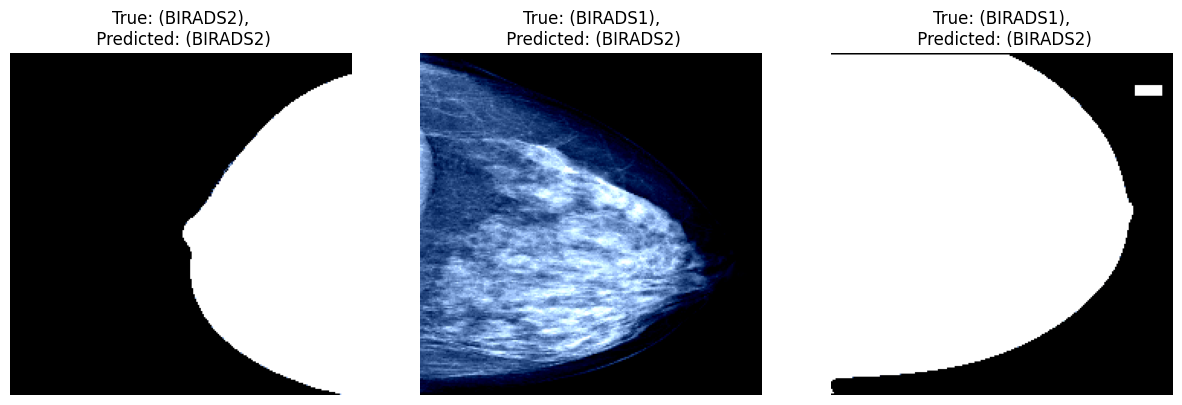

Epoch 3/9
----------


Training Epoch 4:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.


Validation Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 1.0339 Train Acc: 0.5542 Valid Loss: 1.2033 Valid Acc: 0.4761


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.210292..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1345534].


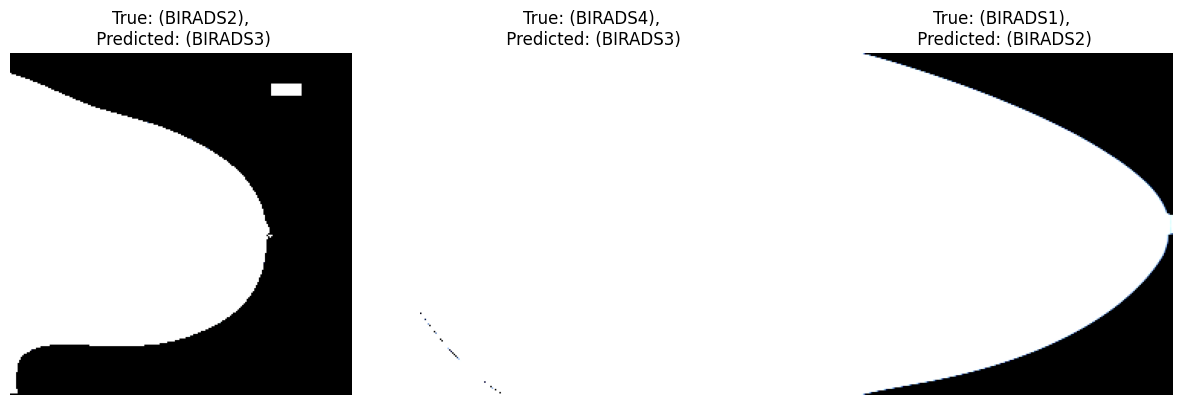

Epoch 4/9
----------


Training Epoch 5:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.


Validation Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.9103 Train Acc: 0.6183 Valid Loss: 1.1825 Valid Acc: 0.4874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.385098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


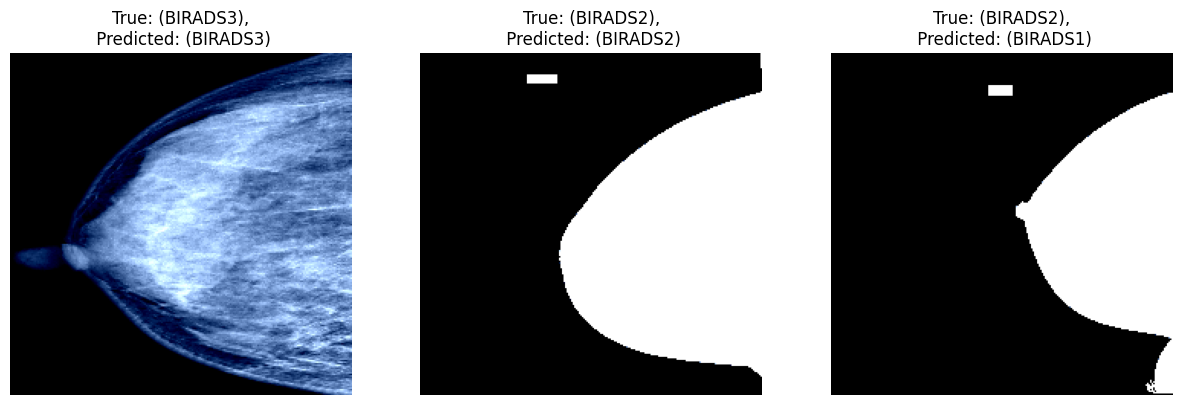

Epoch 5/9
----------


Training Epoch 6:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.


Validation Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.7602 Train Acc: 0.6950 Valid Loss: 1.2110 Valid Acc: 0.5227
Error loading image at index 459. Replacing with previous valid image.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.099695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


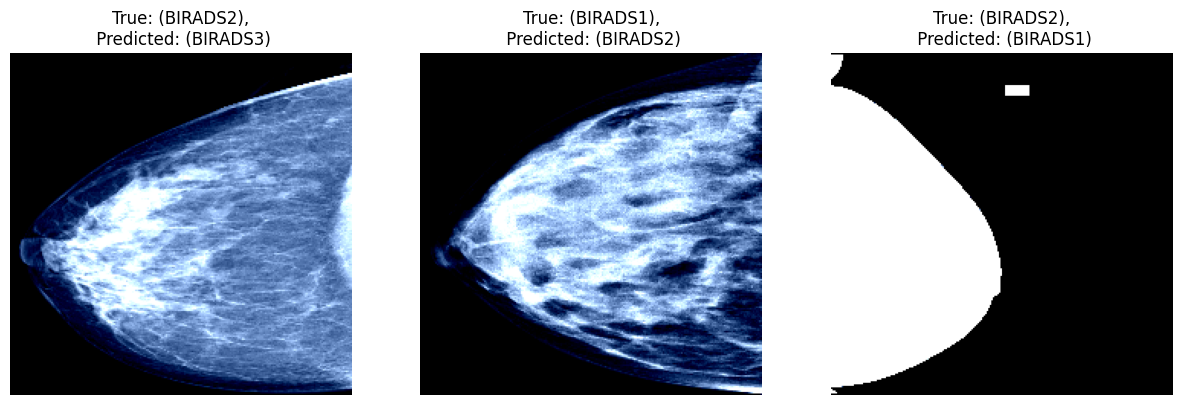

Epoch 6/9
----------


Training Epoch 7:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.


Validation Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.6288 Train Acc: 0.7497 Valid Loss: 1.2428 Valid Acc: 0.5277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.55939].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5942483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


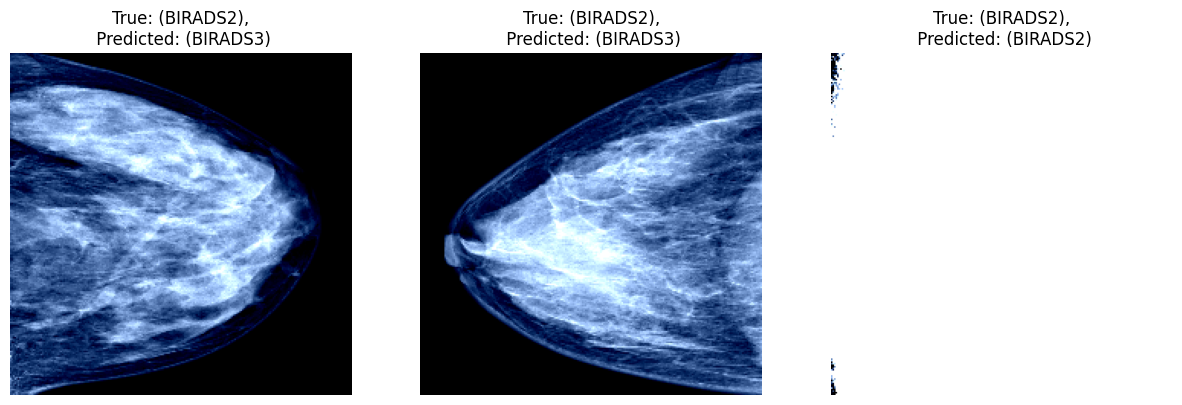

Epoch 7/9
----------


Training Epoch 8:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.


Validation Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.5536 Train Acc: 0.7839 Valid Loss: 1.3983 Valid Acc: 0.5277
Epoch 8/9
----------


Training Epoch 9:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.


Validation Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.4388 Train Acc: 0.8322 Valid Loss: 1.3244 Valid Acc: 0.5378


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6639651].


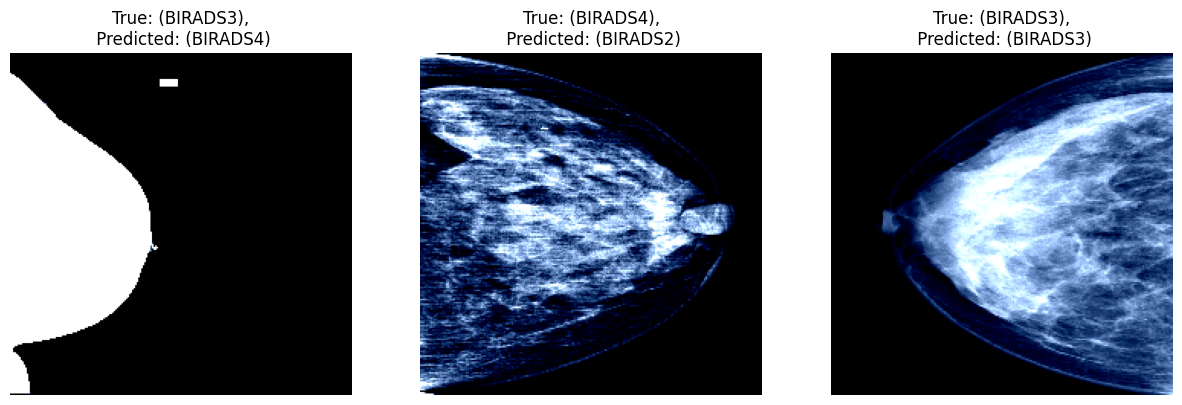

Epoch 9/9
----------


Training Epoch 10:   0%|          | 0/112 [00:00<?, ?it/s]

Error loading image at index 1546. Replacing with previous valid image.
Error loading image at index 1602. Replacing with previous valid image.
Error loading image at index 5693. Replacing with previous valid image.
Error loading image at index 174. Replacing with previous valid image.
Error loading image at index 4822. Replacing with previous valid image.
Error loading image at index 5204. Replacing with previous valid image.
Error loading image at index 1563. Replacing with previous valid image.
Error loading image at index 3796. Replacing with previous valid image.
Error loading image at index 4859. Replacing with previous valid image.
Error loading image at index 1683. Replacing with previous valid image.


Validation Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

Error loading image at index 459. Replacing with previous valid image.
Train Loss: 0.4044 Train Acc: 0.8518 Valid Loss: 1.3347 Valid Acc: 0.5315
Best accuracy 0.5377833753148614


In [28]:
model_eff = Efficient().to(device)
learning_rate = 1e-4
n_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1,verbose=True)
optimizer = optim.Adam(model_eff.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=2,verbose=True) 

new_model, train_loss, valid_loss = train_model(model_eff, criterion, optimizer, scheduler, loaders, n_epochs)

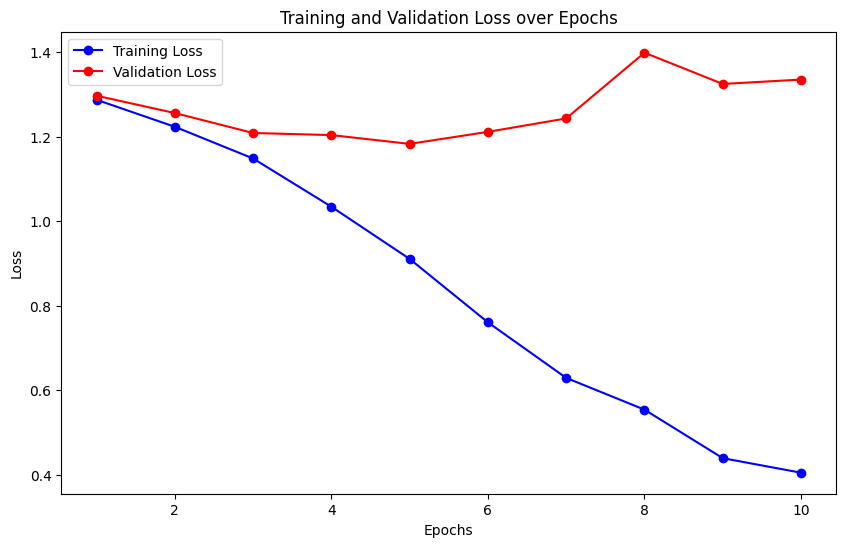

In [29]:
# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, valid_loss, 'ro-', label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Display the plot
plt.show()

In [32]:
preds, labels = testpreds(new_model, test_dataloader)

testing:   0%|          | 0/14 [00:00<?, ?it/s]

Error loading image at index 277. Replacing with previous valid image.
Error loading image at index 565. Replacing with previous valid image.
Error loading image at index 790. Replacing with previous valid image.
Got 463 / 882 with accuracy 52.49


In [35]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds,target_names=list(birads_mapping.keys())))

              precision    recall  f1-score   support

     BIRADS1       0.29      0.20      0.24       126
     BIRADS2       0.60      0.51      0.55       352
     BIRADS3       0.46      0.74      0.57       241
     BIRADS4       0.73      0.49      0.59       163

    accuracy                           0.52       882
   macro avg       0.52      0.49      0.49       882
weighted avg       0.54      0.52      0.52       882

